In this notebook we present comparison of [learning curves](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) of best performing models trained in notebook `02. Training ML models`.

This comparison justifies that using more data wont further improve the estimation errors.

In [1]:
# load test dataset
import numpy as np

input_and_output = np.load("../final/dataset.npz")
inputs  = input_and_output["inputs"].astype(np.float64)
outputs = input_and_output["outputs"].astype(np.float64)

dataset_size = inputs.shape[0]
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.15)

# dropping treatment column in input
def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

input_without_treatment = drop_treatment(inputs)
print("dropped treatment column")

LOWER_LIMIT = -7
PCA_COMPONENTS = 11

def output_transform(outputs: np.array) -> np.array:
    x = np.copy(outputs)
    zeros_in_output = x <= 0
    x[zeros_in_output] = 1
    y = np.log10(x)
    y[zeros_in_output] = LOWER_LIMIT
    y[y < LOWER_LIMIT] = LOWER_LIMIT
    return y
    
def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs < LOWER_LIMIT
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

def apply_size_limit(outputs: np.array) -> np.array:
    x = np.copy(outputs)
    x[x < LOWER_LIMIT] = LOWER_LIMIT
    return x

def apply_absolute_size_limit(outputs: np.array) -> np.array:
    limit = 10 ** LOWER_LIMIT
    x = np.copy(outputs)
    x[x < limit] = 0
    return x

outputs_order_of_magnitude = output_transform(outputs)
print("transformed to orders of magnitude")

from sklearn.decomposition import PCA
import pickle
from pathlib import Path

with Path(f"../final/pca/{PCA_COMPONENTS}_{LOWER_LIMIT}.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

X_train = input_without_treatment[:train_size, :]
Y_train_absolute = apply_absolute_size_limit(outputs[:train_size, :])
X_test = input_without_treatment[train_size:(train_size + test_size), :]
Y_test_absolute = apply_absolute_size_limit(outputs[train_size:(train_size + test_size), :])
Y_train = outputs_order_of_magnitude[:train_size, :]
Y_test = outputs_order_of_magnitude[train_size:(train_size + test_size), :]
Y_train_pca = pca.transform(Y_train)

dropped treatment column
transformed to orders of magnitude


In [2]:
# scaler class

from sklearn.preprocessing import MinMaxScaler


LOGNORMAL_PARAMETERS = (1, 2)
class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res

with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)
    
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
import time
import psutil
import os
import signal

class TimeoutError(Exception):
    pass

def timeout_handler(*args):
    raise TimeoutError(f"timeout {args}")

def keyboard_interrupt_handler(*args):
    os.kill(os.getpid(), signal.SIGINT)
    
signal.signal(signal.SIGALRM, timeout_handler)

try:
    signal.alarm(2)
    time.sleep(1)
    signal.alarm(0)
    print(f"1. no exception")
except TimeoutError as e:
    print(f"1. message: {e}") 
except KeyboardInterrupt as e:
    print(f"1. KEYBOARD: {e}") 

try:
    signal.alarm(2)
    time.sleep(5)
    signal.alarm(0)
    print(f"2. no exception")
except TimeoutError as e:
    print(f"2. message: {e}")
except KeyboardInterrupt as e:
    print(f"2. keyboard: {e}") 

1. no exception
2. message: timeout (14, <frame at 0x147c90880, file '/var/folders/qb/5x7bjvl92hsf3fdzklmgtxm40000gn/T/ipykernel_56198/1398699701.py', line 29, code <module>>)


In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from collections import defaultdict

PREFIX_SIZES = [10000, 50000, 100000, 200000, 350000, 500000, 700000]

training_times = defaultdict(list)
order_errors = defaultdict(list)
asolute_errors = defaultdict(list)
evaluation_times = defaultdict(list)

In [31]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from cpuinfo import get_cpu_info
import json


for model_name, model_factory, params_factory in [
    ("KNN", lambda params: KNeighborsRegressor(**params), lambda k: {
          "n_neighbors": 10,
          "weights": "distance",
          "n_jobs": -1
        },
    ),
    ("randomforrest", lambda params: RandomForestRegressor(**params), lambda k: {
          "n_estimators": 120,
          "criterion": "squared_error",
          "min_samples_split": 4,
          "bootstrap": True,
          "max_samples": 0.12583896439593575,
          "max_features": 4,
          "n_jobs": -1,
          "random_state": 42
        }
    ),
    ("ElasticNet", lambda params: make_pipeline(PolynomialFeatures(4), ElasticNet(**params)), lambda k: {
            "alpha": 0.0024004134957575202,
            "fit_intercept": True,
            "l1_ratio": 0.9137461284265193,
            "max_iter": 10000,
            "random_state": 42,
            "warm_start": k > 0 
        }
    ),
    ("MLPRegressor", lambda params: MLPRegressor(**params), lambda k: {
            "alpha": 0.0040005316095293,
            "batch_size": 10000,
            "hidden_layer_sizes": [600, 100, 40],
            "learning_rate": "constant",
            "learning_rate_init": 0.00016798744315656234,
            "max_iter": 600,
            "n_iter_no_change": 5,
            "random_state": 42,
            "tol": 1e-05,
            "epsilon": 1e-08,
            "verbose": True,
            "warm_start": k > 0
        }
    )
]:
    results_path = Path(f"../final/learning_curve_{model_name}.json")
    if results_path.is_file():
        with results_path.open("r") as opened_file:
            metadata = json.load(opened_file)
            training_times[model_name]   = metadata["training_time_s"]
            evaluation_times[model_name] = metadata["test_evaluation_s"]
            order_errors[model_name]     = metadata["test_error_orders_of_magnitude"]
            asolute_errors[model_name]   = metadata["test_error_absolute"]
        continue
        
    model_params_list = []
    for k, prefix_size in enumerate(PREFIX_SIZES):
        model_params = params_factory(k)
        model_params_list.append(model_params)
        model = model_factory(model_params)
        
        start_time = time.time()
        model.fit(X_train_scaled[:prefix_size, :], Y_train_pca[:prefix_size, :])
        training_time_s = int(time.time() - start_time)
        training_times[model_name].append(training_time_s)
        print(f"trained prefix {prefix_size} in {training_time_s}s")

        start_time = time.time()
        test_result_orders   = apply_size_limit(pca.inverse_transform(model.predict(X_test_scaled)))
        test_evaluation_s = int(time.time() - start_time)
        evaluation_times[model_name].append(test_evaluation_s)
        error_test_orders    = mean_squared_error(Y_test, test_result_orders)

        print(f"orders MSE {error_test_orders} calculated in {test_evaluation_s}s")

        test_result_absolute = output_untransform(test_result_orders)
        error_test_absolute  = mean_squared_error(Y_test_absolute, test_result_absolute)
        print(f"absolute MSE {error_test_absolute}")

        order_errors[model_name].append(error_test_orders)
        asolute_errors[model_name].append(error_test_absolute)
    with results_path.open("w") as opened_file:
        opened_file.write(json.dumps({
                "cpu_info": {key: get_cpu_info()[key] for key in ["arch", "bits", "brand_raw", "count"]},
                "pca_components": PCA_COMPONENTS,
                "tumour_lower_size_limit_l": 10 ** LOWER_LIMIT,
                "tumour_lower_size_limit_log10_l": LOWER_LIMIT,
                "model_params": model_params_list,
                "test_dataset": "[700000:850000] of ../final/dataset.npz",
                "test_error_orders_of_magnitude": order_errors[model_name],
                "test_error_absolute": asolute_errors[model_name],
                "train_dataset": f"[:700000] of ../final/dataset.npz",
                "train_prefixes": PREFIX_SIZES,
                "training_time_s": training_times[model_name],
                "test_evaluation_s": evaluation_times[model_name]
        }, sort_keys=True, indent=4))

trained prefix 10000 in 61s
orders MSE 0.1090845122636518 calculated in 0s
absolute MSE 3.4884027998254604e+229
trained prefix 50000 in 473s
orders MSE 0.05682126327003365 calculated in 0s
absolute MSE 2.5709527499886136e+66
trained prefix 100000 in 2074s
orders MSE 0.0531811127224202 calculated in 1s
absolute MSE 5.873389937417621e+37
trained prefix 200000 in 1793s
orders MSE 0.052017208848169495 calculated in 0s
absolute MSE 1.120991107895985e+25
trained prefix 350000 in 2423s
orders MSE 0.051711165499761194 calculated in 0s
absolute MSE 4.3883754099569934e+22
trained prefix 500000 in 3219s
orders MSE 0.05115852806466901 calculated in 0s
absolute MSE 519165384805.7318
trained prefix 700000 in 4941s
orders MSE 0.050892599521947995 calculated in 0s
absolute MSE 3.530018536926113e-05


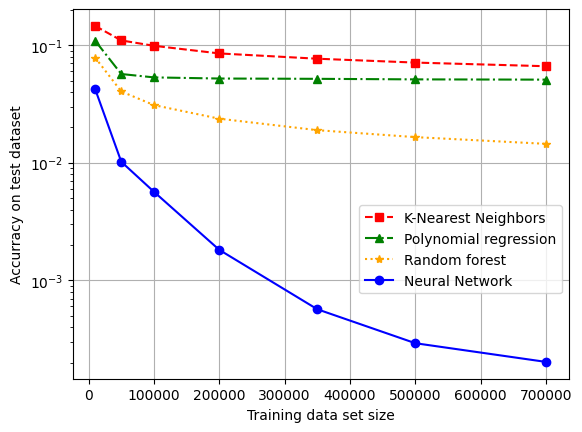

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.yscale('log')
plt.grid()
plt.plot(PREFIX_SIZES, order_errors["KNN"], color='red', marker='s', linestyle='--', label='K-Nearest Neighbors')
plt.plot(PREFIX_SIZES, order_errors["ElasticNet"], color='green', marker='^', linestyle='-.', label='Polynomial regression')
plt.plot(PREFIX_SIZES, order_errors["randomforrest"], color='orange', marker='*', linestyle=':', label='Random forest')
plt.plot(PREFIX_SIZES, order_errors["MLPRegressor"], color='blue', marker='o', linestyle='-', label='Neural Network')
plt.legend(bbox_to_anchor=(1, 0.35), loc="center right", ncol=1)
plt.ylabel("Accurracy on test dataset")
plt.xlabel("Training data set size")


plt.show()

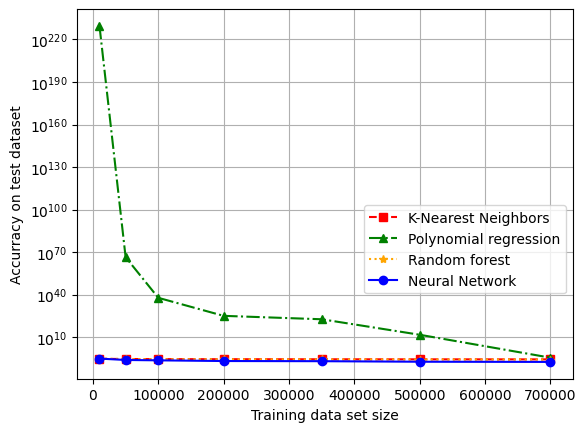

In [34]:
plt.yscale('log')
plt.grid()
plt.plot(PREFIX_SIZES, asolute_errors["KNN"], color='red', marker='s', linestyle='--', label='K-Nearest Neighbors')
plt.plot(PREFIX_SIZES, asolute_errors["ElasticNet"], color='green', marker='^', linestyle='-.', label='Polynomial regression')
plt.plot(PREFIX_SIZES, asolute_errors["randomforrest"], color='orange', marker='*', linestyle=':', label='Random forest')
plt.plot(PREFIX_SIZES, asolute_errors["MLPRegressor"], color='blue', marker='o', linestyle='-', label='Neural Network')
plt.legend(bbox_to_anchor=(1, 0.35), loc="center right", ncol=1)
plt.ylabel("Accurracy on test dataset")
plt.xlabel("Training data set size")


plt.show()

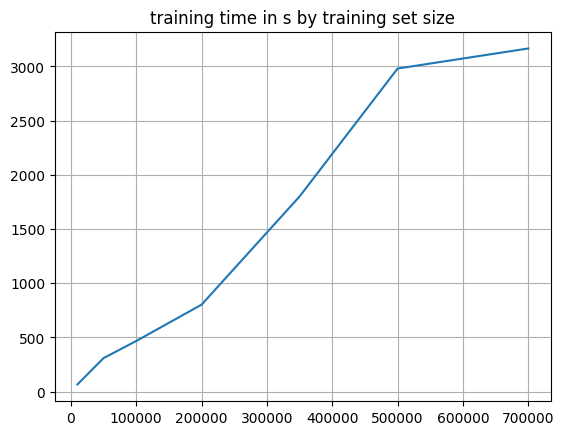

In [7]:
import matplotlib.pyplot as plt

plt.title("training time in s by training set size")
plt.grid()
plt.plot(PREFIX_SIZES, training_times)
plt.show()